In [2]:
import pandas as pd
import numpy as np
import json

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [3]:
df_labels= 'data.info.txt'
df_labels = pd.read_csv(df_labels, delimiter=',')

In [4]:
df_raw = 'dataset0.json'

# Open the file and read line by line (each line = one read)
with open(df_raw, 'r') as file:
    data_list = []
    for line in file:
        try:
            data = json.loads(line)  # Parse each line as a separate JSON object
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(f"Error message: {e}")

# Optionally pretty-print the first JSON object for readability
if data_list:
    formatted_data = json.dumps(data_list[0], indent=4)
    print(formatted_data)

{
    "ENST00000000233": {
        "244": {
            "AAGACCA": [
                [
                    0.00299,
                    2.06,
                    125.0,
                    0.0177,
                    10.4,
                    122.0,
                    0.0093,
                    10.9,
                    84.1
                ],
                [
                    0.00631,
                    2.53,
                    125.0,
                    0.00844,
                    4.67,
                    126.0,
                    0.0103,
                    6.3,
                    80.9
                ],
                [
                    0.00465,
                    3.92,
                    109.0,
                    0.0136,
                    12.0,
                    124.0,
                    0.00498,
                    2.13,
                    79.6
                ],
                [
                    0.00398,
                    2.06,
                    

In [5]:
print(len(df_labels))
print(df_labels[0:5])

121838
           gene_id    transcript_id  transcript_position  label
0  ENSG00000004059  ENST00000000233                  244      0
1  ENSG00000004059  ENST00000000233                  261      0
2  ENSG00000004059  ENST00000000233                  316      0
3  ENSG00000004059  ENST00000000233                  332      0
4  ENSG00000004059  ENST00000000233                  368      0


In [6]:
print(len(data_list))
for dat in data_list[0:5]:
    print(dat)
    for _,pos in dat.items():
        for _,seq in pos.items():
            for _, measurements in seq.items():
                continue

121838
{'ENST00000000233': {'244': {'AAGACCA': [[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0.0093, 10.9, 84.1], [0.00631, 2.53, 125.0, 0.00844, 4.67, 126.0, 0.0103, 6.3, 80.9], [0.00465, 3.92, 109.0, 0.0136, 12.0, 124.0, 0.00498, 2.13, 79.6], [0.00398, 2.06, 125.0, 0.0083, 5.01, 130.0, 0.00498, 3.78, 80.4], [0.00664, 2.92, 120.0, 0.00266, 3.94, 129.0, 0.013, 7.15, 82.2], [0.0103, 3.83, 123.0, 0.00598, 6.45, 126.0, 0.0153, 1.09, 74.8], [0.00398, 3.75, 126.0, 0.00332, 4.3, 129.0, 0.00299, 1.93, 81.9], [0.00498, 3.93, 127.0, 0.00398, 2.51, 131.0, 0.0111, 3.47, 79.4], [0.0139, 4.69, 106.0, 0.0136, 6.21, 124.0, 0.00531, 10.6, 85.5], [0.00631, 3.5, 126.0, 0.0222, 5.38, 128.0, 0.00332, 1.72, 79.3], [0.0061, 3.99, 121.0, 0.0121, 7.27, 122.0, 0.00232, 1.27, 78.9], [0.00299, 1.99, 128.0, 0.00427, 4.85, 124.0, 0.00332, 3.18, 80.5], [0.0186, 3.62, 124.0, 0.00428, 2.25, 129.0, 0.00554, 2.78, 80.1], [0.0093, 3.12, 125.0, 0.00398, 8.84, 129.0, 0.00361, 1.86, 82.0], [0.00365, 2.92, 126.0, 0.00698, 3.

In [7]:
unique_gene_ids = df_labels['gene_id'].nunique()
gene_id_counts = df_labels['gene_id'].value_counts()

unique_transcript_ids = df_labels['transcript_id'].nunique()
transcript_id_counts = df_labels['transcript_id'].value_counts()

label_counts = df_labels['label'].value_counts()

print(unique_gene_ids)
print(unique_transcript_ids)
print(label_counts)

3852
5333
label
0    116363
1      5475
Name: count, dtype: int64


In [8]:
# aggregating data_list
def create_aggregated_dataframe(data_list):
    rows = []
    for data in data_list:
        for transcript_id, positions in data.items():
            for position, sequence_data in positions.items():
                for sequence, measurements in sequence_data.items():
                    # Convert to numpy array for easier aggregation
                    scores_array = np.array(measurements)
                    
                    # Calculate the mean, sum, max, and min along the rows
                    mean_scores = np.mean(scores_array, axis=0)
                    sum_scores = np.sum(scores_array, axis=0)
                    max_scores = np.max(scores_array, axis=0)
                    min_scores = np.min(scores_array, axis=0)

                    transcript_position = {
                        'transcript_id': transcript_id,
                        'transcript_position': position,
                    }
                    
                    for idx in range(scores_array.shape[1]): 

                        transcript_position.update({
                            f'mean {idx}': mean_scores[idx],
                            f'sum {idx}': sum_scores[idx],
                            f'max {idx}': max_scores[idx],
                            f'min {idx}': min_scores[idx]
                        })
                    rows.append(transcript_position)
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    return df

# Create the DataFrame
aggregated_df = create_aggregated_dataframe(data_list)

In [9]:
print(aggregated_df[0:5])

     transcript_id transcript_position    mean 0    sum 0   max 0    min 0  \
0  ENST00000000233                 244  0.008264  1.52891  0.0339  0.00199   
1  ENST00000000233                 261  0.006609  1.13679  0.0222  0.00199   
2  ENST00000000233                 316  0.007570  1.40045  0.0299  0.00232   
3  ENST00000000233                 332  0.010620  2.12405  0.0370  0.00232   
4  ENST00000000233                 368  0.010701  2.11870  0.0478  0.00199   

     mean 1     sum 1  max 1  min 1  ...   max 6    min 6    mean 7    sum 7  \
0  4.223784   781.400   13.4  1.770  ...  0.0329  0.00232  4.386989  811.593   
1  3.216424   553.225   17.0  0.919  ...  0.0262  0.00232  3.016599  518.855   
2  2.940541   544.000   11.6  1.280  ...  0.0266  0.00199  2.087146  386.122   
3  6.476350  1295.270   14.2  1.220  ...  0.0214  0.00199  2.236520  447.304   
4  6.415051  1270.180   39.0  1.150  ...  0.0485  0.00266  4.260253  843.530   

   max 7  min 7     mean 8    sum 8  max 8  min 8 

In [10]:
df_labels['transcript_position'] = df_labels['transcript_position'].astype(int)
aggregated_df['transcript_position'] = aggregated_df['transcript_position'].astype(int)

In [11]:
df_full = pd.merge(aggregated_df, df_labels[['transcript_id', 'transcript_position', 'label']],
                   on=['transcript_id', 'transcript_position'], how='left')


df_full = df_full.groupby('transcript_id').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42))

# Reset the index to avoid hierarchical indexing after using apply
df_full = df_full.reset_index(drop=True)
print(df_full)


         transcript_id  transcript_position    mean 0    sum 0   max 0  \
0      ENST00000000233                  244  0.008264  1.52891  0.0339   
1      ENST00000000233                  261  0.006609  1.13679  0.0222   
2      ENST00000000233                  471  0.006060  1.24833  0.0285   
3      ENST00000000233                  404  0.009011  1.73011  0.0277   
4      ENST00000000233                  332  0.010620  2.12405  0.0370   
...                ...                  ...       ...      ...     ...   
47713  ENST00000641834                  610  0.008452  0.57474  0.0313   
47714  ENST00000641834                 1093  0.008520  0.62193  0.0219   
47715  ENST00000641834                  474  0.006436  0.42480  0.0190   
47716  ENST00000641834                 1531  0.008161  0.52228  0.0315   
47717  ENST00000641834                 1348  0.009594  0.70035  0.0432   

         min 0    mean 1     sum 1  max 1  min 1  ...    min 6    mean 7  \
0      0.00199  4.223784   781.400 

C:\Users\andre\AppData\Local\Temp\ipykernel_17820\1411437272.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_full = df_full.groupby('transcript_id').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42))


In [12]:
print(df_full[['transcript_id', 'transcript_position', 'label']][0:5])

     transcript_id  transcript_position  label
0  ENST00000000233                  244      0
1  ENST00000000233                  261      0
2  ENST00000000233                  471      0
3  ENST00000000233                  404      0
4  ENST00000000233                  332      0


In [13]:
df_full['label'] = df_full['label'].fillna(0)

In [14]:
df_full[0:5]
df_working = df_full.copy()

In [15]:
x = df_working.drop(columns=['transcript_id', 'transcript_position','label'], axis=1)
y = df_full['label']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

BASELINE MODELS

In [17]:
# optional scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [117]:
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [118]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(report)

Accuracy: 0.952745180217938
ROC AUC: 0.547138214585664
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     18135
           1       0.69      0.10      0.17       953

    accuracy                           0.95     19088
   macro avg       0.82      0.55      0.57     19088
weighted avg       0.94      0.95      0.94     19088



XGBoost classifier

In [119]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:03:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [120]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(report)

Accuracy: 0.9542120704107293
ROC AUC: 0.6075607596170843
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     18135
           1       0.61      0.22      0.33       953

    accuracy                           0.95     19088
   macro avg       0.79      0.61      0.65     19088
weighted avg       0.94      0.95      0.94     19088



SMOTE testing

In [18]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Print the class distribution before and after applying SMOTE
print("Original class distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Class distribution after SMOTE:", dict(zip(*np.unique(y_train_smote, return_counts=True))))

Original class distribution: {np.int64(0): np.int64(27225), np.int64(1): np.int64(1405)}
Class distribution after SMOTE: {np.int64(0): np.int64(27225), np.int64(1): np.int64(27225)}


In [19]:
model = RandomForestClassifier()
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(report)

Accuracy: 0.9432627829002515
ROC AUC: 0.6803383218608483
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     18135
           1       0.43      0.39      0.41       953

    accuracy                           0.94     19088
   macro avg       0.70      0.68      0.69     19088
weighted avg       0.94      0.94      0.94     19088



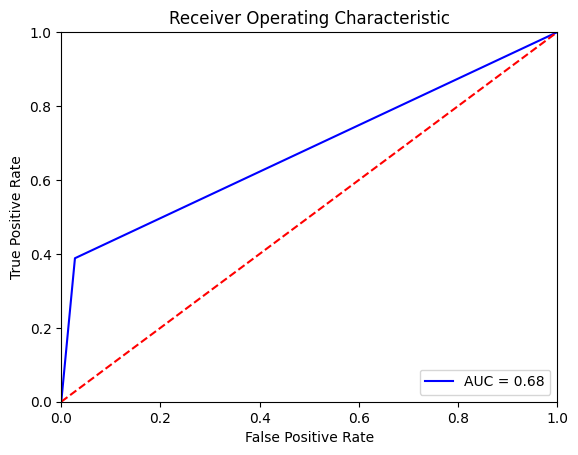

In [21]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [22]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test_scaled)

c:\Users\andre\OneDrive\Desktop\y4s1\grp_proj\lib\site-packages\xgboost\core.py:158: UserWarning: [16:52:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [23]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(report)

Accuracy: 0.9467728415758592
ROC AUC: 0.6444068923437979
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     18135
           1       0.45      0.31      0.37       953

    accuracy                           0.95     19088
   macro avg       0.71      0.64      0.67     19088
weighted avg       0.94      0.95      0.94     19088



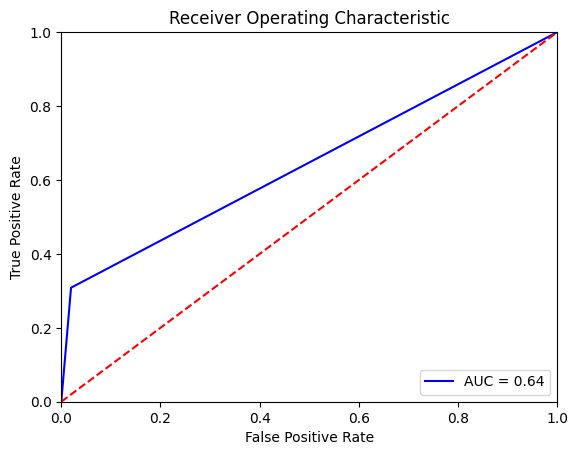

In [24]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()